### Imports necesarios

In [252]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

from tensorflow import keras
from tensorflow.keras import layers

## 1. Introducción
### En este cuaderno vamos a analizar el historico de acciones en bolsa de la empresa Take-Two Interactive Software, Inc. (TTWO), conocida en la industria de los videojuegos por juegos como la saga Grand Theft Auto, Borderlands, Red Dead, BioShock, Mafia: The City of Lost Heaven, WWE y más
### Origen de los datos: https://finance.yahoo.com/quote/TTWO/history/

## 2. Carga de datos y presentación de columnas

In [253]:
df = pd.read_csv("TTWO_historical_data.csv")
df.head()

,Date,Close,High,Low,Open,Volume
0,1997-04-15,3.916425,3.916425,3.416456,3.666441,1785600
1,1997-04-16,3.708104,4.166410,3.583112,3.916425,443700
2,1997-04-17,3.833096,4.083081,3.749768,3.749768,252150
3,1997-04-18,3.999753,3.999753,3.833096,3.833096,165900
4,1997-04-21,3.999753,3.999753,3.916425,3.916425,77400


### **Date:** Fecha de la cotización en formato AAAA-MM-DD.
### **Close:** Precio de cierre de la acción al final de la jornada bursátil.
### **High:** Precio más alto alcanzado por la acción durante el día.
### **Low:** Precio más bajo alcanzado por la acción durante el día.
### **Open:** Precio de apertura de la acción al inicio de la jornada bursátil.
### **Volume:** Número total de acciones negociadas en ese día.

In [254]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7031 entries, 0 to 7030
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    7031 non-null   object 
 1   Close   7031 non-null   float64
 2   High    7031 non-null   float64
 3   Low     7031 non-null   float64
 4   Open    7031 non-null   float64
 5   Volume  7031 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 329.7+ KB


None

In [255]:
display(df.describe())

,Close,High,Low,Open,Volume
count,7031.000000,7031.000000,7031.000000,7031.000000,7.031000e+03
mean,50.671251,51.402618,49.913069,50.671638,1.725066e+06
std,57.061557,57.749930,56.334312,57.064362,1.861216e+06
min,3.333127,3.416456,2.999815,3.249799,0.000000e+00
25%,11.430000,11.662973,11.150000,11.399648,9.049000e+05
50%,19.652121,20.080000,19.268811,19.678786,1.373550e+06
75%,102.105000,103.299999,99.905003,101.555000,2.024200e+06
max,217.949997,218.750000,212.460007,218.589996,5.279740e+07


In [256]:
df.isna().sum()

Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

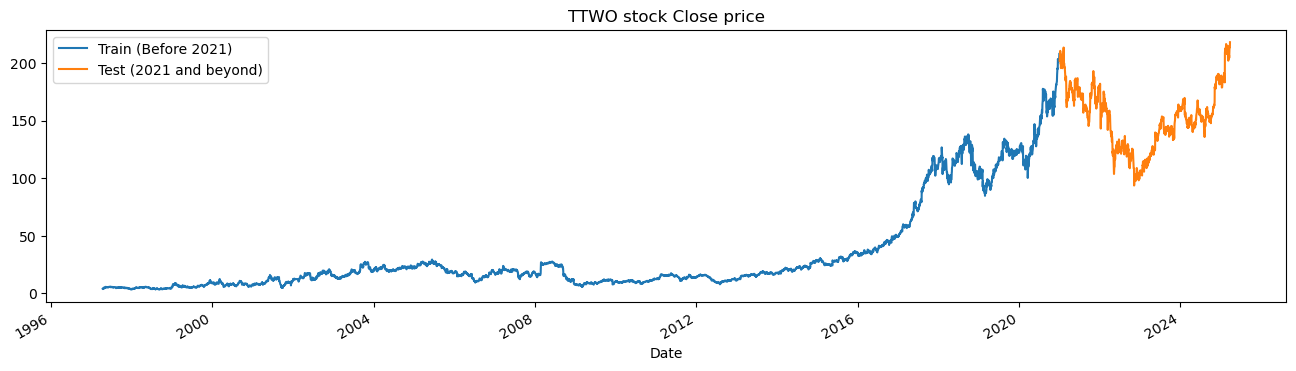

In [257]:
# Convertir 'Date' a datetime
df['Date'] = pd.to_datetime(df['Date'])

# Establecer la columna 'Date' como índice
df.set_index('Date', inplace=True)

# Función para graficar
tstart = 1997
tend = 2020

def train_test_plot(df, tstart, tend):
    df.loc[f"{tstart}":f"{tend}", "Close"].plot(figsize=(16, 4), legend=True)
    df.loc[f"{tend+1}":, "Close"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("TTWO stock Close price")
    plt.show()

# Llamar a la función
train_test_plot(df, tstart, tend)

### Dividimos el conjunto de pruebas y el de validación

In [258]:
def train_test_split(df, tstart, tend):
    train = df.loc[f"{tstart}":f"{tend}", "Close"].values
    test = df.loc[f"{tend+1}":, "Close"].values
    return train, test
training_set, test_set = train_test_split(df, tstart, tend)

### Estandarizamos los datos para eliminar valoires atípicos y anómalias

In [259]:
sc = MinMaxScaler(feature_range=(0, 1))
# Hacer el reshape es necesario porque MinMaxScaler
# espera una entrada en forma de columnas, donde cada fila representa una muestra y cada columna una característica.
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

### Construis X_train y y_train

In [260]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 20
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)

In [261]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)
print(X_train.shape)

(5950, 20, 1)


In [284]:
X_train.shape

(5950, 20, 1)

## Modelo LSTM

In [263]:
"""
set_seed(23)
np.random.seed(23)

# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mae")

model_lstm.summary()
"""

'\nset_seed(23)\nnp.random.seed(23)\n\n# The LSTM architecture\nmodel_lstm = Sequential()\nmodel_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))\nmodel_lstm.add(Dense(units=1))\n# Compiling the model\nmodel_lstm.compile(optimizer="RMSprop", loss="mae")\n\nmodel_lstm.summary()\n'

### Mismo modelo usando la API funcional

In [264]:
set_seed(23)
np.random.seed(23)

# Definir la entrada
inputs = keras.Input(shape=(n_steps, features))

# Capa LSTM
x = layers.LSTM(units=125, activation="tanh")(inputs)

# Capa densa de salida
outputs = layers.Dense(units=1)(x)

# Crear el modelo
model_lstm = keras.Model(inputs=inputs, outputs=outputs)

# Compilar el modelo
model_lstm.compile(optimizer="Adam", loss="mae")

# Resumen del modelo
model_lstm.summary()

Model: "functional_78"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_35 (InputLayer)     │ (None, 20, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 125)            │        63,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,626 (248.54 KB)

 Trainable params: 63,626 (248.54 KB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento del modelo

In [265]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0192
Epoch 2/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0049
Epoch 3/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0058
Epoch 4/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0045
Epoch 5/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0047
Epoch 6/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0039
Epoch 7/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0036
Epoch 8/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0037
Epoch 9/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0036
Epoch 10/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0036
Epoch 11/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0034
Epoch 12/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0034
Epoch 13/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0033
Epoch 14/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0034
Epoch 15/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - lo

In [266]:
dataset_total = df.loc[:,"Close"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_stock_price = model_lstm.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [267]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("TTWO Stock Close Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("TTWO Stock Close Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

def return_mae(test, predicted):
    mae = mean_absolute_error(test, predicted)
    print("The mean absolute error is {:.2f}.".format(mae))

def return_mape(test, predicted):
    mape = mean_absolute_percentage_error(test, predicted) * 100
    print("The mean absolute percentage error is {:.2f}%".format(mape))

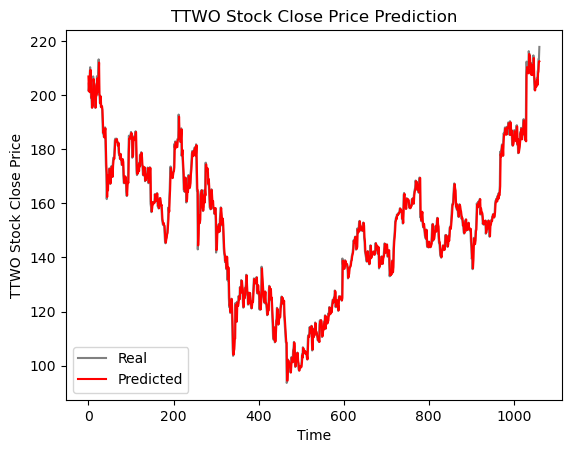

In [268]:
plot_predictions(test_set,predicted_stock_price)

In [269]:
return_mae(test_set,predicted_stock_price)
return_mape(test_set,predicted_stock_price)

The mean absolute error is 2.10.
The mean absolute percentage error is 1.41%


## Modelo GRU

In [270]:
set_seed(23)
np.random.seed(23)

model_gru = Sequential()
model_gru.add(GRU(units=125, activation="tanh", input_shape=(n_steps, features)))
model_gru.add(Dense(units=1))
# Compiling the RNN
model_gru.compile(optimizer="RMSprop", loss="mae")

model_gru.summary()

/home/alumnadotarde/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_36 (GRU)                    │ (None, 125)            │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,126 (187.99 KB)

 Trainable params: 48,126 (187.99 KB)

 Non-trainable params: 0 (0.00 B)

In [271]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0314
Epoch 2/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0114
Epoch 3/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0098
Epoch 4/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0089
Epoch 5/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0083
Epoch 6/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0078
Epoch 7/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0074
Epoch 8/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0071
Epoch 9/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0068
Epoch 10/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0065
Epoch 11/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0065
Epoch 12/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0063
Epoch 13/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0061
Epoch 14/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0060
Epoch 15/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - lo

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


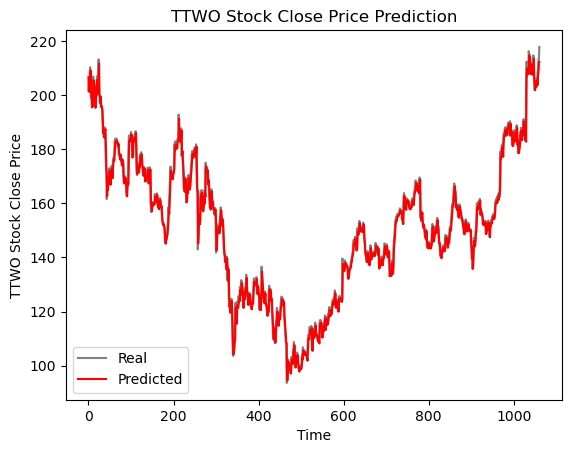

In [272]:
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
plot_predictions(test_set, GRU_predicted_stock_price)

In [273]:
return_mae(test_set,GRU_predicted_stock_price)
return_mape(test_set,GRU_predicted_stock_price)

The mean absolute error is 2.21.
The mean absolute percentage error is 1.48%


## Modelo GRU 2

In [274]:
set_seed(23)
np.random.seed(23)

model_gru2 = Sequential()
# El parámetro return_sequences es necesario para añadir más capas
model_gru2.add(GRU(units=125, activation="tanh", input_shape=(n_steps, features), return_sequences=True))
model_gru2.add(GRU(units=125, activation="tanh"))
model_gru2.add(Dense(units=1))

model_gru2.compile(optimizer="Adam", loss="mae")

model_gru2.summary()

model_gru2.fit(X_train, y_train, epochs=50, batch_size=32)

/home/alumnadotarde/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_37 (GRU)                    │ (None, 20, 125)        │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_38 (GRU)                    │ (None, 125)            │        94,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,626 (557.13 KB)

 Trainable params: 142,626 (557.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0175
Epoch 2/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0045
Epoch 3/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0054
Epoch 4/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0043
Epoch 5/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0036
Epoch 6/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0040
Epoch 7/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0036
Epoch 8/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0037
Epoch 9/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0040
Epoch 10/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0040
Epoch 11/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0035
Epoch 12/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0041
Epoch 13/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0035
Epoch 14/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0042
Epoch 15/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


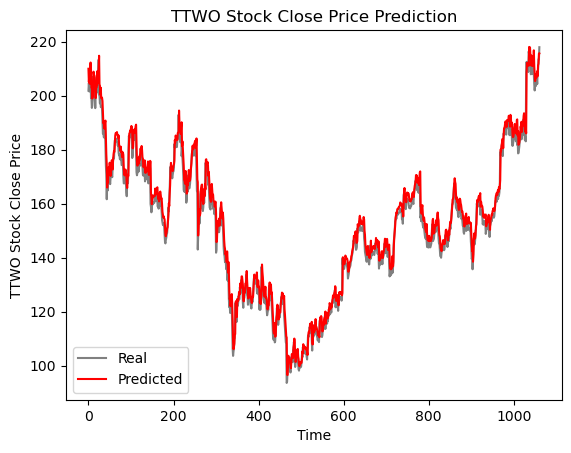

In [275]:
GRU_predicted_stock_price2 = model_gru2.predict(X_test)
GRU_predicted_stock_price2 = sc.inverse_transform(GRU_predicted_stock_price2)
plot_predictions(test_set, GRU_predicted_stock_price2)

In [276]:
return_mae(test_set,GRU_predicted_stock_price2)
return_mape(test_set,GRU_predicted_stock_price2)

The mean absolute error is 2.96.
The mean absolute percentage error is 1.98%


## Modelo GRU 3

In [277]:
set_seed(23)
np.random.seed(23)

model_gru3 = Sequential()
# El parámetro return_sequences es necesario para añadir más capas
model_gru3.add(GRU(units=64, activation="tanh", input_shape=(n_steps, features)))
model_gru3.add(Dense(units=1))

model_gru3.compile(optimizer="RMSprop", loss="mae")

model_gru3.summary()

model_gru3.fit(X_train, y_train, epochs=50, batch_size=32)

/home/alumnadotarde/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_39 (GRU)                    │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,929 (50.50 KB)

 Trainable params: 12,929 (50.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0315
Epoch 2/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0101
Epoch 3/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0090
Epoch 4/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0083
Epoch 5/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0078
Epoch 6/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0074
Epoch 7/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0071
Epoch 8/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068
Epoch 9/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0065
Epoch 10/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0064
Epoch 11/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0062
Epoch 12/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0060
Epoch 13/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0059
Epoch 14/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0058
Epoch 15/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


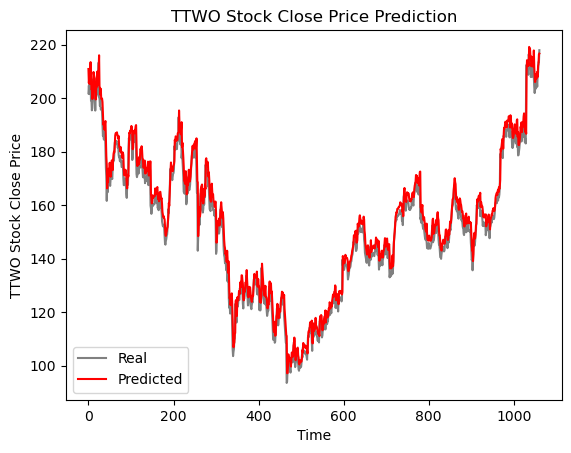

In [278]:
GRU_predicted_stock_price3 = model_gru3.predict(X_test)
GRU_predicted_stock_price3 = sc.inverse_transform(GRU_predicted_stock_price3)
plot_predictions(test_set, GRU_predicted_stock_price3)

In [279]:
return_mae(test_set,GRU_predicted_stock_price3)
return_mape(test_set,GRU_predicted_stock_price3)

The mean absolute error is 3.41.
The mean absolute percentage error is 2.29%


### Media de las acciones diarias de cierre desde 1997 hasta la fecha actual:
### 50

| Modelo                            | Tamaño de Ventana | MAE  | Tiempo       | MAPE       |
|-----------------------------------|-------------------|------|--------------|--------------|
| **LSTM (1 capa con 125, Adam)**   | 50                | 2.26 | 1min, 32s    |              |
| **GRU (1 capa con 125, RMSprop)** | 50                | 2.32 | 1min, 31s    |               |
| **GRU2 (2 capas con 125, Adam)**  | 50                | 2.14 | 3min, 2s     |               |
| **GRU3 (1 capa con 64, RMSprop)** | 50                | 2.54 | 47s          |                |
| **LSTM (1 capa con 125, Adam)**   | 120               | 2.26 | 3min, 37s    |                 |
| **GRU (1 capa con 125, RMSprop)** | 120               | 2.67 | 3min, 39s    |                 |
| **GRU2 (2 capas con 125, Adam)**  | 120               | 2.75 | 8min, 18s    |                 |
| **GRU3 (1 capa con 64, RMSprop)** | 120               | 2.62 | 2min, 8s     |                 |
| **LSTM (1 capa con 125, Adam)**   | **20**            | **2.10** | **1m**   |     **1.41%**       |
| **GRU (1 capa con 125, RMSprop)** | 20                | 2.21 | 46s |     1.48%       |
| **GRU2 (2 capas con 125, Adam)**  | 20                | 2.96 | 1min, 45s    |     1.98%       |
| **GRU3 (1 capa con 64, RMSprop)** | 20                | 3.41 | 26s         |        2.29%     |
| **LSTM (1 capa con 125, Adam)**   | 7                 | 2.32 | 22s         |                  |
| **GRU (1 capa con 125, RMSprop)** | 7                 | 2.35 | 22s         |                  |
| **GRU2 (2 capas con 125, Adam)**  | 7                 | 2.30 | 46s         |                  |
| **GRU3 (1 capa con 64, RMSprop)** | 7                 | 2.16 | 14s         |                  |

## Intento de mejora del mejor modelo 20 steps:
### GRU con:
* 1 capa con 125 neuronas
* RMSprop

In [280]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

# Establecer la semilla para reproducibilidad
set_seed(23)
np.random.seed(23)

# Crear el modelo GRU con hiperparámetros ajustados
model_gru_h = Sequential()
model_gru_h.add(GRU(units=128, activation="tanh", input_shape=(n_steps, features), kernel_regularizer=l2(0.01), return_sequences=True))
model_gru_h.add(GRU(units=64, activation="tanh"))
model_gru_h.add(Dropout(0.2))
model_gru_h.add(Dense(units=1))

# Compilando el modelo
optimizer = Adam(learning_rate=0.001)
model_gru_h.compile(optimizer=optimizer, loss="mae")

# Resumen del modelo
model_gru_h.summary()

# Entrenamiento del modelo
model_gru_h.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

/home/alumnadotarde/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_40 (GRU)                    │ (None, 20, 128)        │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_41 (GRU)                    │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,617 (342.25 KB)

 Trainable params: 87,617 (342.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0470 - val_loss: 0.0462
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0142 - val_loss: 0.0432
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0136 - val_loss: 0.0219
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0113 - val_loss: 0.0461
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0122 - val_loss: 0.0267
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0098 - val_loss: 0.0185
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0102 - val_loss: 0.0354
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0098 - val_loss: 0.0240
Epoch 9/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0095 - val_loss: 0.0169
Epoch 10/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0098 - val_loss: 0.0274
Epoch 11/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0104 - val_loss: 0.0223
Epoch 12/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


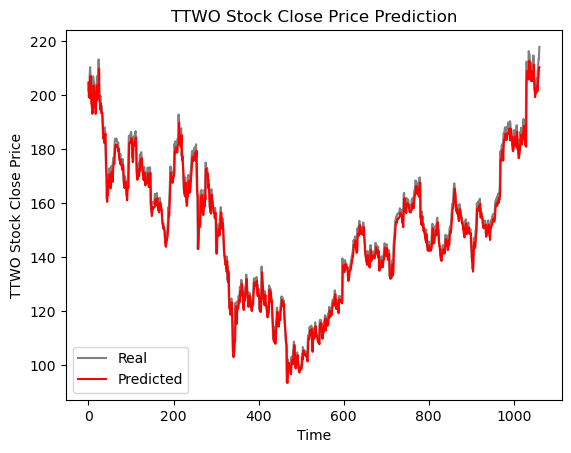

In [281]:
# Predicción con el modelo ajustado
GRU_predicted_stock_price_h = model_gru_h.predict(X_test)

# Inversión de la normalización para obtener los valores reales
GRU_predicted_stock_price_h = sc.inverse_transform(GRU_predicted_stock_price_h)
plot_predictions(test_set, GRU_predicted_stock_price_h)

In [282]:
return_mae(test_set, GRU_predicted_stock_price_h)
#The mean absolute error is 2.27. (PARA 20 steps)
return_mape(test_set,GRU_predicted_stock_price_h)

The mean absolute error is 2.61.
The mean absolute percentage error is 1.72%


## Intento de mejora del mejor modelo 50 steps:
### LSTM con:
* 1 capa con 125 neuronas
* Adam

/home/alumnadotarde/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 20, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0475 - val_loss: 0.0340
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0159 - val_loss: 0.0257
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0125 - val_loss: 0.0247
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0133 - val_loss: 0.0573
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0120 - val_loss: 0.0237
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0120 - val_loss: 0.0293
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0114 - val_loss: 0.0330
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0108 - val_loss: 0.0417
Epoch 9/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0111 - val_loss: 0.0282
Epoch 10/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0109 - val_loss: 0.0432
Epoch 11/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0106 - val_loss: 0.0311
Epoch 12/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

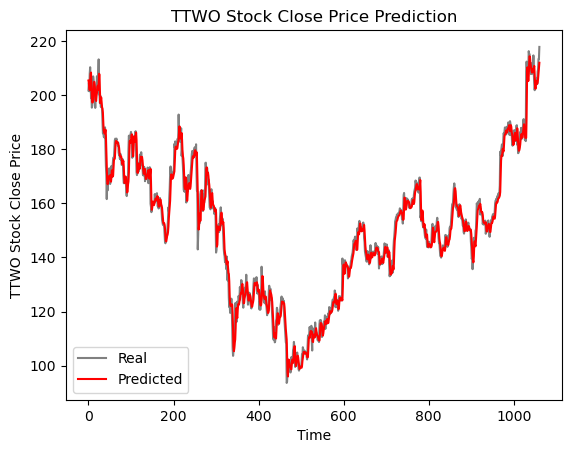

The mean absolute error is 2.70.
The mean absolute percentage error is 1.72%


In [283]:
from keras import layers, models
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

# Establecer la semilla para reproducibilidad
set_seed(23)
np.random.seed(23)

# Crear el modelo LSTM con hiperparámetros ajustados
model_lstm_h = models.Sequential()

# Primera capa LSTM con regularización
model_lstm_h.add(layers.LSTM(units=128, activation='tanh', input_shape=(n_steps, features),
                              kernel_regularizer=l2(0.01), return_sequences=True))

# Segunda capa LSTM
model_lstm_h.add(layers.LSTM(units=64, activation='tanh'))

# Capa de Dropout para evitar el sobreajuste
model_lstm_h.add(layers.Dropout(0.2))

# Capa de salida densa
model_lstm_h.add(layers.Dense(units=1))

# Compilar el modelo
optimizer = Adam(learning_rate=0.001)
model_lstm_h.compile(optimizer=optimizer, loss='mae')

# Resumen del modelo
model_lstm_h.summary()

# Entrenamiento del modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_lstm_h.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test),
                 callbacks=[early_stopping])

# Realizar predicciones
predicted_stock_price_h = model_lstm_h.predict(X_test)

# Deshacer la transformación de los valores
predicted_stock_price_h = sc.inverse_transform(predicted_stock_price_h)

# Graficar las predicciones
plot_predictions(test_set, predicted_stock_price_h)

# Calcular el MAE
return_mae(test_set, predicted_stock_price_h)

# Calcular el MAPE
return_mape(test_set,GRU_predicted_stock_price_h)